In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set styling for better visualizations
plt.style.use('seaborn-v0_8')  # Using the correct style name
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [2]:

df = pd.read_parquet('./data/yellow_tripdata_2024-01.parquet')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nFirst few rows:")
print("-" * 50)
print(df.head())

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  

In [3]:
# Cell 3: Basic statistics and data quality check
print("Missing Values Analysis:")
print("-" * 50)
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentages
})
print(missing_stats[missing_stats['Missing Values'] > 0])

print("\nBasic Statistics for Numerical Columns:")
print("-" * 50)
print(df.describe())

Missing Values Analysis:
--------------------------------------------------
                      Missing Values  Missing Percentage
passenger_count               140162            4.727817
RatecodeID                    140162            4.727817
store_and_fwd_flag            140162            4.727817
congestion_surcharge          140162            4.727817
Airport_fee                   140162            4.727817

Basic Statistics for Numerical Columns:
--------------------------------------------------
           VendorID  passenger_count  trip_distance    RatecodeID  \
count  2.964624e+06     2.824462e+06   2.964624e+06  2.824462e+06   
mean   1.754204e+00     1.339281e+00   3.652169e+00  2.069359e+00   
std    4.325902e-01     8.502817e-01   2.254626e+02  9.823219e+00   
min    1.000000e+00     0.000000e+00   0.000000e+00  1.000000e+00   
25%    2.000000e+00     1.000000e+00   1.000000e+00  1.000000e+00   
50%    2.000000e+00     1.000000e+00   1.680000e+00  1.000000e+00   
75%    

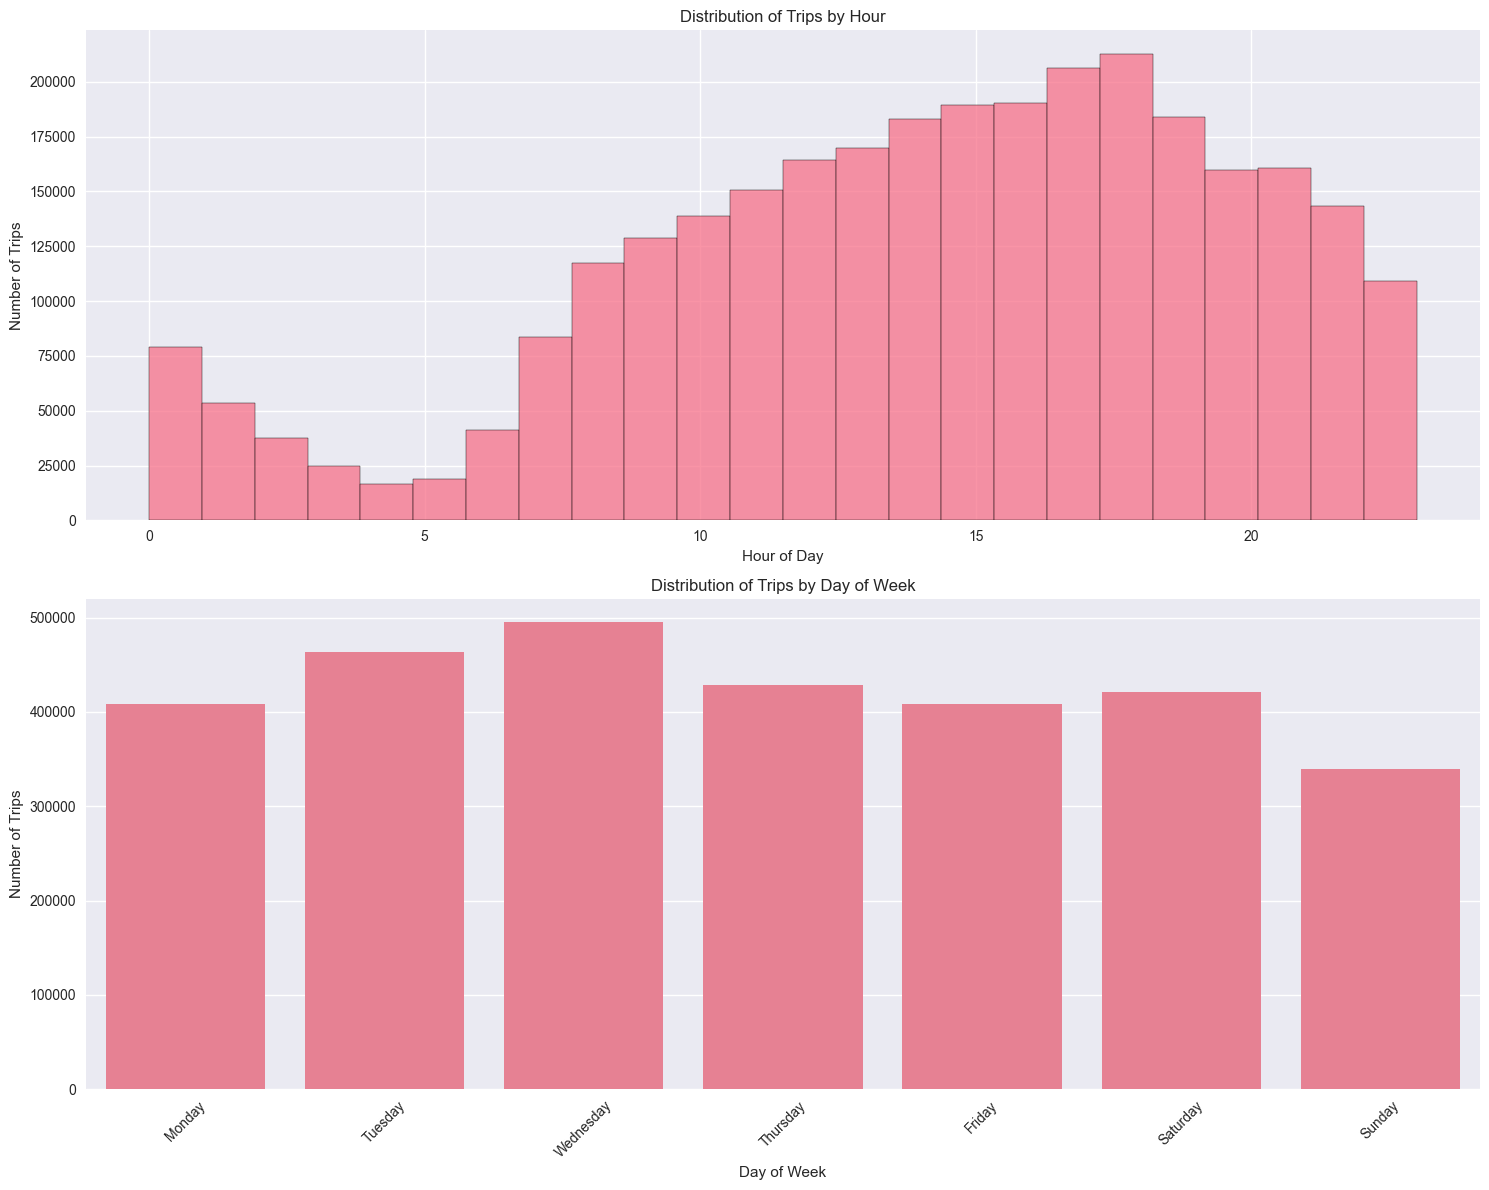

In [4]:
# Cell 4: Temporal distribution analysis
# Convert tpep_pickup_datetime to datetime if not already
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Add derived time features
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day'] = df['tpep_pickup_datetime'].dt.day
df['day_of_week'] = df['tpep_pickup_datetime'].dt.day_name()

# Create temporal visualizations
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Trips by hour
sns.histplot(data=df, x='hour', bins=24, ax=axes[0])
axes[0].set_title('Distribution of Trips by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trips')

# Trips by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='day_of_week', order=day_order, ax=axes[1])
axes[1].set_title('Distribution of Trips by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Trips')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

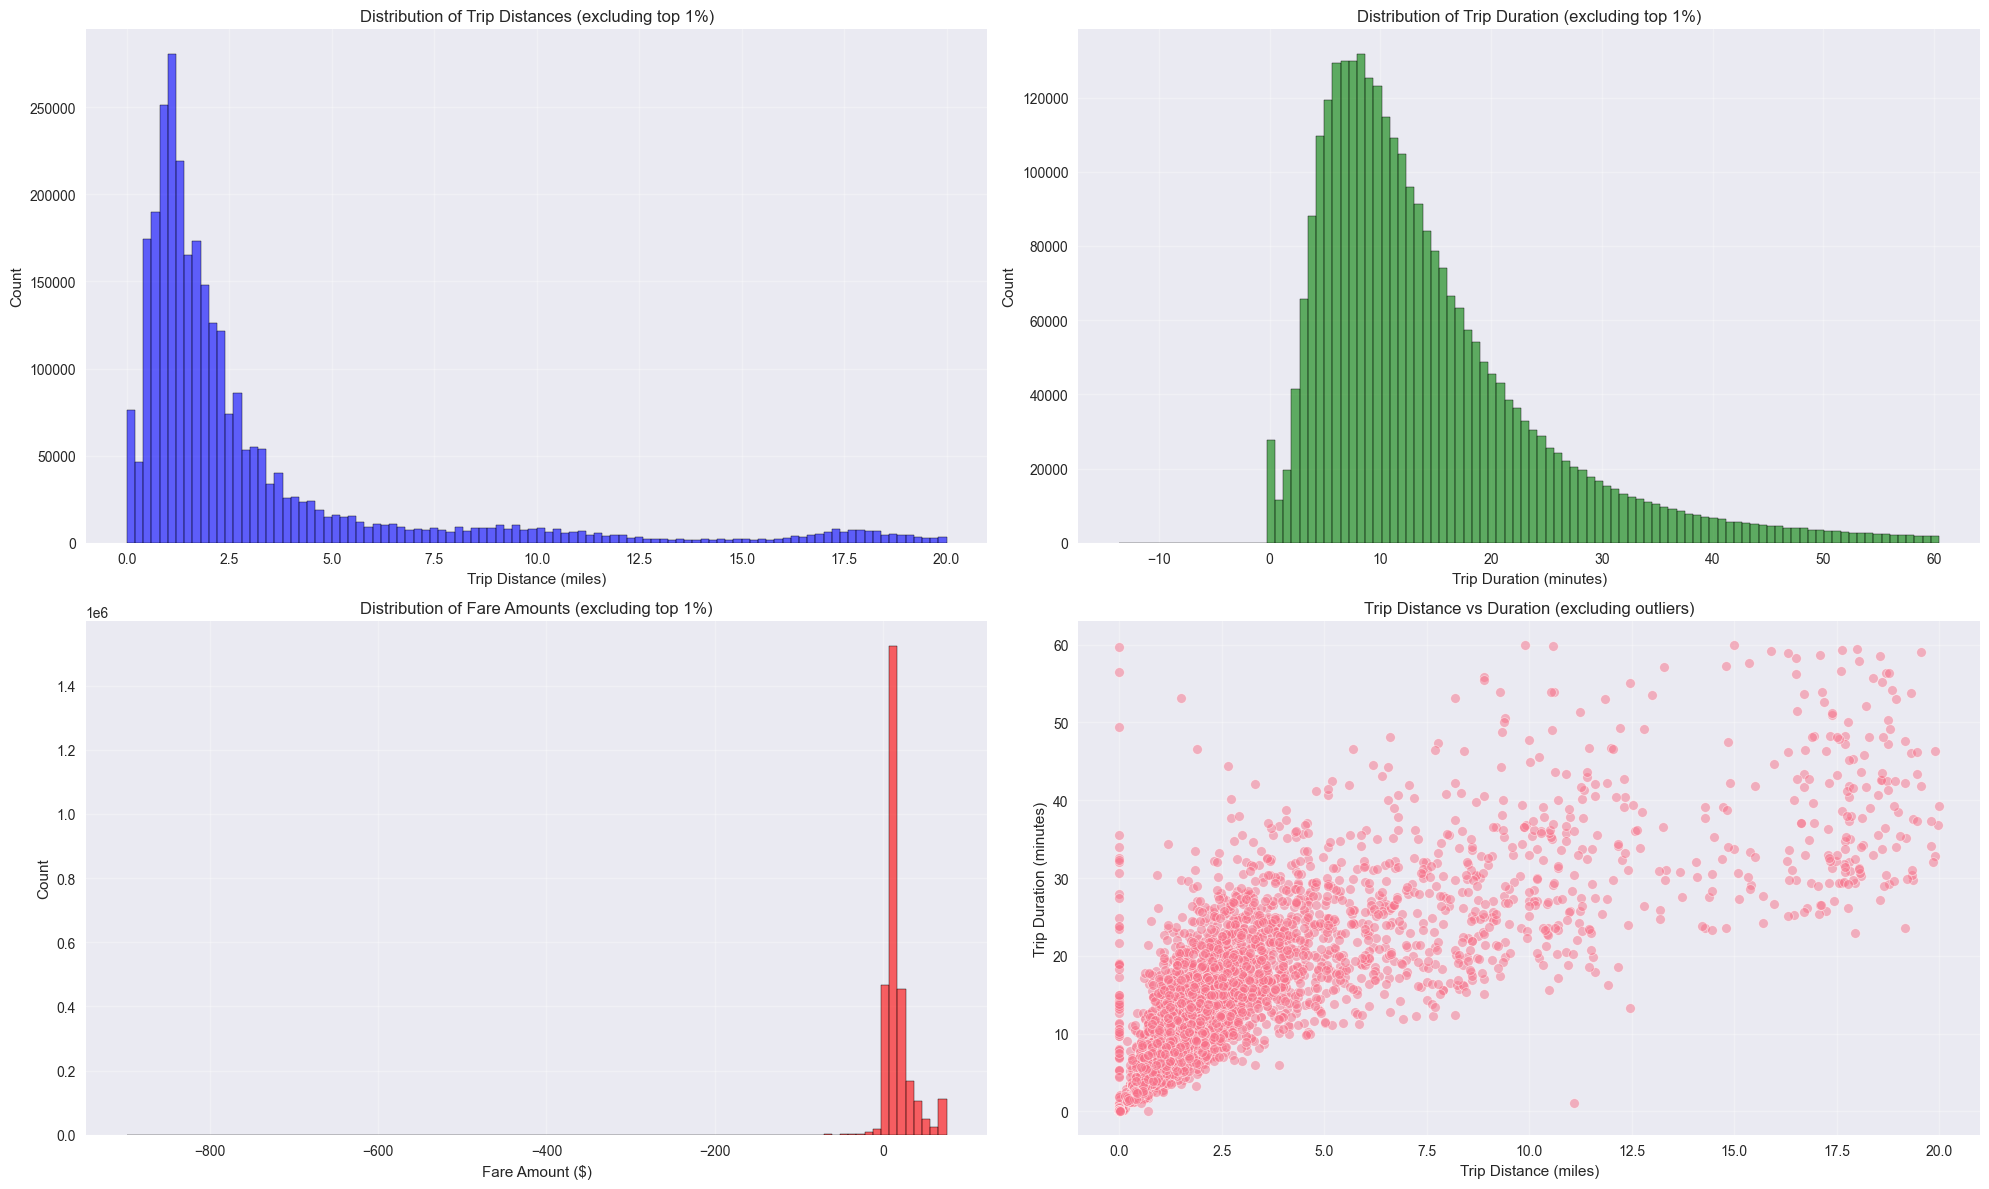


Basic Statistics (excluding outliers):
--------------------------------------------------

Trip Distance (miles):
count    2.935105e+06
mean     3.017234e+00
std      3.800235e+00
min      0.000000e+00
25%      9.900000e-01
50%      1.660000e+00
75%      3.040000e+00
max      2.000000e+01
Name: trip_distance, dtype: float64

Trip Duration (minutes):
count    2.935030e+06
mean     1.426048e+01
std      1.024824e+01
min     -1.356667e+01
25%      7.116667e+00
50%      1.153333e+01
75%      1.838333e+01
max      6.045000e+01
Name: trip_duration, dtype: float64

Fare Amount ($):
count    2.935099e+06
mean     1.730477e+01
std      1.552091e+01
min     -8.990000e+02
25%      8.600000e+00
50%      1.280000e+01
75%      1.980000e+01
max      7.580000e+01
Name: fare_amount, dtype: float64


In [5]:
# Cell 5: Improved trip metrics analysis
# Calculate trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Create visualization for trip metrics with improved parameters
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Trip distance distribution - improved
sns.histplot(data=df[df['trip_distance'] <= df['trip_distance'].quantile(0.99)], 
            x='trip_distance', 
            bins=100,
            ax=axes[0,0],
            color='blue',
            alpha=0.6)
axes[0,0].set_title('Distribution of Trip Distances (excluding top 1%)', fontsize=12)
axes[0,0].set_xlabel('Trip Distance (miles)')
axes[0,0].grid(True, alpha=0.3)

# Trip duration distribution - improved
sns.histplot(data=df[df['trip_duration'] <= df['trip_duration'].quantile(0.99)], 
            x='trip_duration', 
            bins=100,
            ax=axes[0,1],
            color='green',
            alpha=0.6)
axes[0,1].set_title('Distribution of Trip Duration (excluding top 1%)', fontsize=12)
axes[0,1].set_xlabel('Trip Duration (minutes)')
axes[0,1].grid(True, alpha=0.3)

# Fare amount distribution - improved
sns.histplot(data=df[df['fare_amount'] <= df['fare_amount'].quantile(0.99)], 
            x='fare_amount', 
            bins=100,
            ax=axes[1,0],
            color='red',
            alpha=0.6)
axes[1,0].set_title('Distribution of Fare Amounts (excluding top 1%)', fontsize=12)
axes[1,0].set_xlabel('Fare Amount ($)')
axes[1,0].grid(True, alpha=0.3)

# Scatter plot: Distance vs. Duration - improved
# Take a random sample and remove outliers
sample_df = df[
    (df['trip_distance'] <= df['trip_distance'].quantile(0.99)) & 
    (df['trip_duration'] <= df['trip_duration'].quantile(0.99))
].sample(5000)

sns.scatterplot(data=sample_df, 
                x='trip_distance', 
                y='trip_duration', 
                ax=axes[1,1],
                alpha=0.5)
axes[1,1].set_title('Trip Distance vs Duration (excluding outliers)', fontsize=12)
axes[1,1].set_xlabel('Trip Distance (miles)')
axes[1,1].set_ylabel('Trip Duration (minutes)')
axes[1,1].grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nBasic Statistics (excluding outliers):")
print("-" * 50)
print("\nTrip Distance (miles):")
print(df[df['trip_distance'] <= df['trip_distance'].quantile(0.99)]['trip_distance'].describe())
print("\nTrip Duration (minutes):")
print(df[df['trip_duration'] <= df['trip_duration'].quantile(0.99)]['trip_duration'].describe())
print("\nFare Amount ($):")
print(df[df['fare_amount'] <= df['fare_amount'].quantile(0.99)]['fare_amount'].describe())

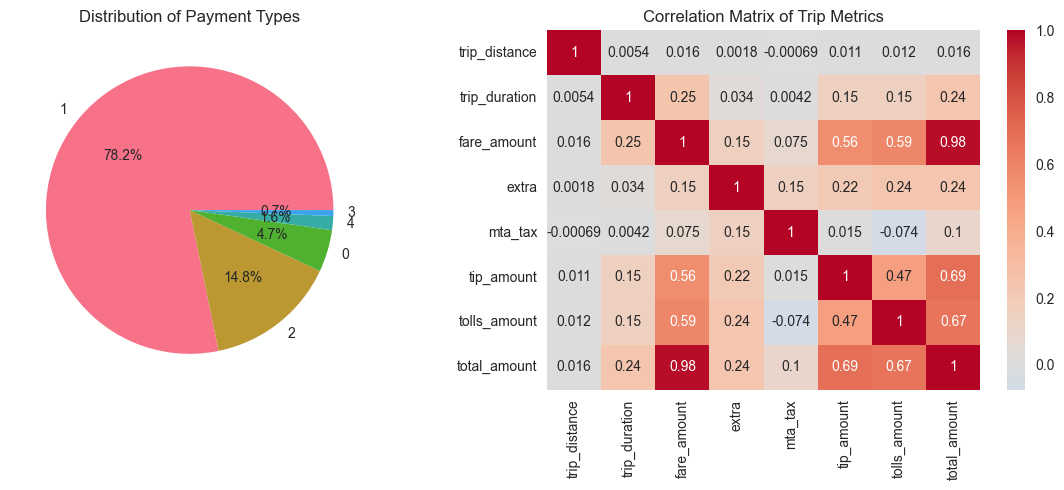


Summary Statistics of Trip Metrics:
--------------------------------------------------
       trip_distance  trip_duration   fare_amount         extra       mta_tax  \
count   2.964624e+06   2.964624e+06  2.964624e+06  2.964624e+06  2.964624e+06   
mean    3.652169e+00   1.561295e+01  1.817506e+01  1.451598e+00  4.833823e-01   
std     2.254626e+02   3.485105e+01  1.894955e+01  1.804102e+00  1.177600e-01   
min     0.000000e+00  -1.356667e+01 -8.990000e+02 -7.500000e+00 -5.000000e-01   
25%     1.000000e+00   7.150000e+00  8.600000e+00  0.000000e+00  5.000000e-01   
50%     1.680000e+00   1.163333e+01  1.280000e+01  1.000000e+00  5.000000e-01   
75%     3.110000e+00   1.868333e+01  2.050000e+01  2.500000e+00  5.000000e-01   
max     3.127223e+05   9.455400e+03  5.000000e+03  1.425000e+01  4.000000e+00   

         tip_amount  tolls_amount  total_amount  
count  2.964624e+06  2.964624e+06  2.964624e+06  
mean   3.335870e+00  5.270212e-01  2.680150e+01  
std    3.896551e+00  2.128310e+0

In [6]:
# Cell 6: Payment patterns and correlations
# Payment type distribution
plt.figure(figsize=(12, 5))
payment_counts = df['payment_type'].value_counts()
plt.subplot(1, 2, 1)
plt.pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Payment Types')

# Correlation matrix of numerical columns
numerical_columns = ['trip_distance', 'trip_duration', 'fare_amount', 
                    'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                    'total_amount']
correlation_matrix = df[numerical_columns].corr()

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Trip Metrics')
plt.tight_layout()
plt.show()

# Print summary statistics of trip metrics
print("\nSummary Statistics of Trip Metrics:")
print("-" * 50)
summary_stats = df[numerical_columns].describe()
print(summary_stats)

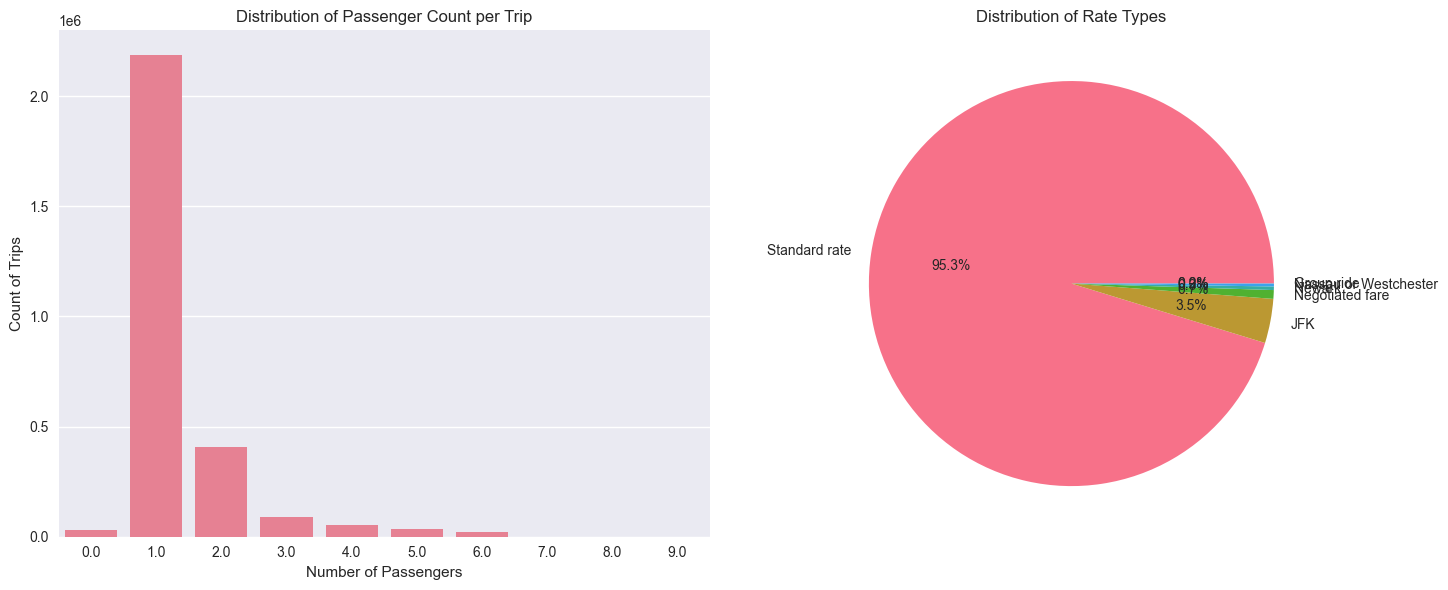


Passenger Count Statistics:
--------------------------------------------------
count    2.824462e+06
mean     1.339281e+00
std      8.502817e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

Rate Type Distribution:
--------------------------------------------------
Standard rate: 2,663,350 trips (89.84%)
JFK: 98,713 trips (3.33%)
Negotiated fare: 19,410 trips (0.65%)
Newark: 7,954 trips (0.27%)
Nassau or Westchester: 6,365 trips (0.21%)
Group ride: 7 trips (0.00%)


In [7]:
# Cell 7: Analyze passenger count and rate type distributions
plt.figure(figsize=(15, 6))

# Passenger count distribution
plt.subplot(1, 2, 1)
passenger_counts = df['passenger_count'].value_counts().sort_index()
sns.barplot(x=passenger_counts.index, y=passenger_counts.values)
plt.title('Distribution of Passenger Count per Trip')
plt.xlabel('Number of Passengers')
plt.ylabel('Count of Trips')

# RateCodeID distribution
plt.subplot(1, 2, 2)
rate_code_map = {
    1: "Standard rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau or Westchester",
    5: "Negotiated fare",
    6: "Group ride"
}
df['RatecodeID_mapped'] = df['RatecodeID'].map(rate_code_map)
rate_counts = df['RatecodeID_mapped'].value_counts()
plt.pie(rate_counts.values, labels=rate_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Rate Types')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPassenger Count Statistics:")
print("-" * 50)
print(df['passenger_count'].describe())
print("\nRate Type Distribution:")
print("-" * 50)
for rate_code, count in rate_counts.items():
    print(f"{rate_code}: {count:,} trips ({count/len(df)*100:.2f}%)")

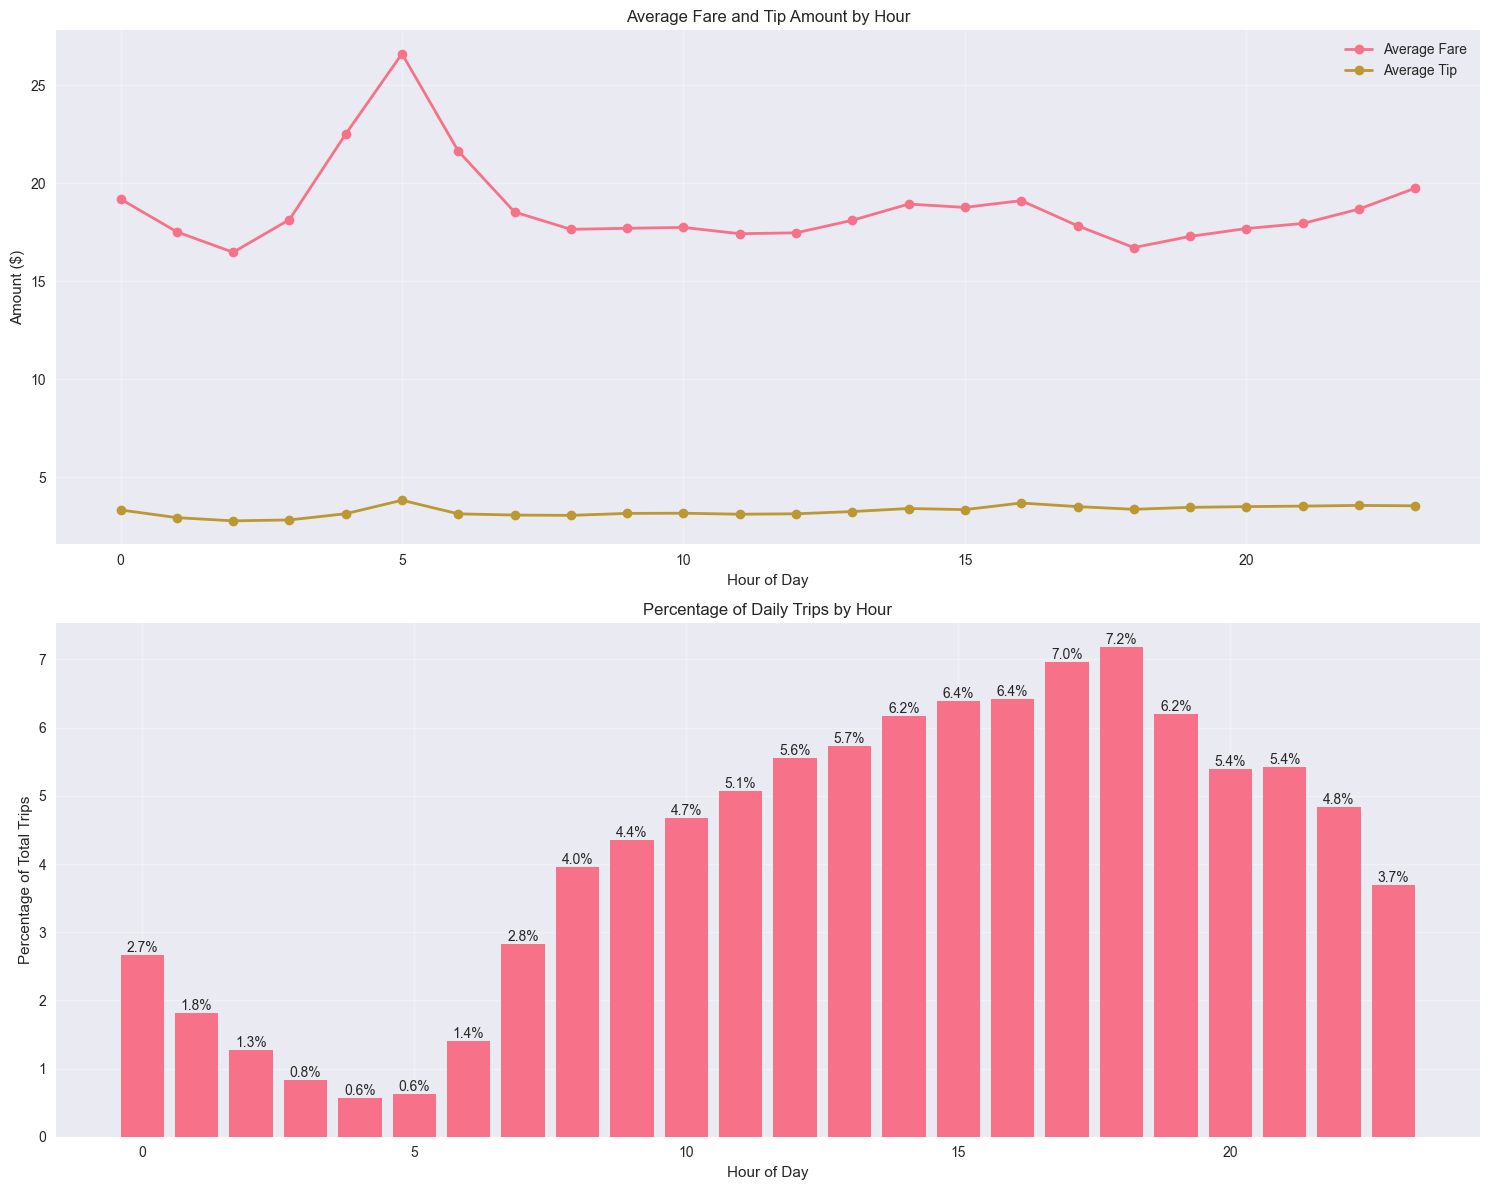


Hourly Statistics Summary:
--------------------------------------------------

Busiest Hours (by trip count):
    hour  total_amount  trip_percentage
18    18        212788         7.177571
17    17        206257         6.957274
16    16        190201         6.415687
15    15        189359         6.387286
19    19        184032         6.207600

Most Profitable Hours (by average fare):
    hour  fare_amount  tip_amount
5      5    26.619918    3.822016
4      4    22.518645    3.132973
6      6    21.650399    3.127463
23    23    19.757696    3.536872
0      0    19.202658    3.326543


In [8]:
# Cell 8: Analyze hourly patterns with fare and tip analysis
# Create hour and day columns if not already created
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day_name'] = df['tpep_pickup_datetime'].dt.day_name()

# Calculate average fare and tips by hour
hourly_stats = df.groupby('hour').agg({
    'fare_amount': 'mean',
    'tip_amount': 'mean',
    'total_amount': 'count'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot average fares and tips by hour
ax1 = axes[0]
ax1.plot(hourly_stats['hour'], hourly_stats['fare_amount'], 
         marker='o', linewidth=2, label='Average Fare')
ax1.plot(hourly_stats['hour'], hourly_stats['tip_amount'], 
         marker='o', linewidth=2, label='Average Tip')
ax1.set_title('Average Fare and Tip Amount by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Amount ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot trip count by hour with percentage labels
ax2 = axes[1]
total_trips = hourly_stats['total_amount'].sum()
hourly_stats['trip_percentage'] = (hourly_stats['total_amount'] / total_trips) * 100

bars = ax2.bar(hourly_stats['hour'], hourly_stats['trip_percentage'])
ax2.set_title('Percentage of Daily Trips by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Percentage of Total Trips')
ax2.grid(True, alpha=0.3)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nHourly Statistics Summary:")
print("-" * 50)
print("\nBusiest Hours (by trip count):")
busiest_hours = hourly_stats.nlargest(5, 'total_amount')
print(busiest_hours[['hour', 'total_amount', 'trip_percentage']])

print("\nMost Profitable Hours (by average fare):")
profitable_hours = hourly_stats.nlargest(5, 'fare_amount')
print(profitable_hours[['hour', 'fare_amount', 'tip_amount']])

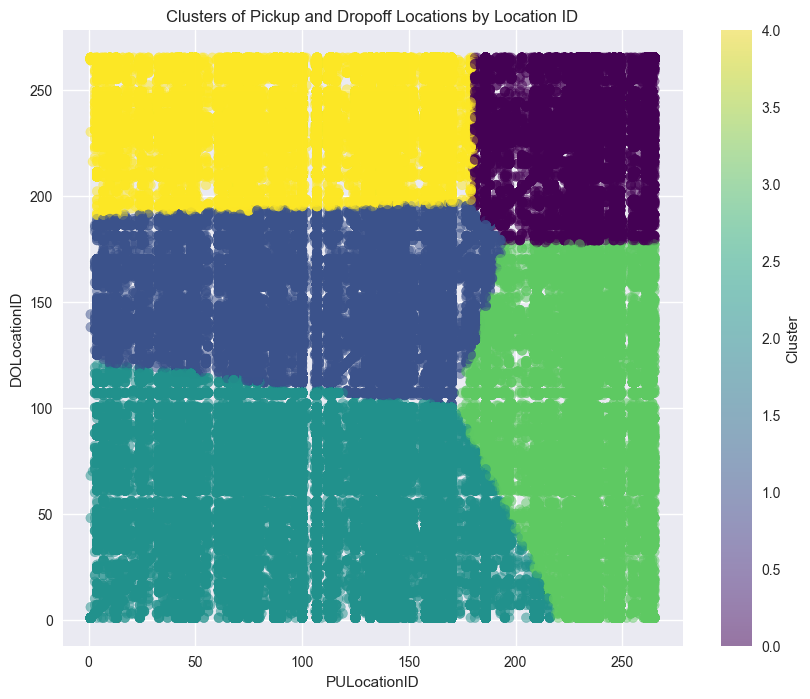

In [9]:
from sklearn.cluster import KMeans

# Clustering based on pickup and dropoff location IDs
location_id_features = df[['PULocationID', 'DOLocationID']]

# Applying KMeans clustering on Location IDs
kmeans = KMeans(n_clusters=5, random_state=0)
df['location_id_cluster'] = kmeans.fit_predict(location_id_features)

# Visualizing the clusters based on PULocationID and DOLocationID
plt.figure(figsize=(10, 8))
plt.scatter(df['PULocationID'], df['DOLocationID'], c=df['location_id_cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('PULocationID')
plt.ylabel('DOLocationID')
plt.title('Clusters of Pickup and Dropoff Locations by Location ID')
plt.show()


In [10]:
from scipy import stats
import numpy as np

# Detecting anomalies using Z-score for fare_amount and trip_distance
z_scores = np.abs(stats.zscore(df[['fare_amount', 'trip_distance']]))
df['z_score'] = np.max(z_scores, axis=1)

# Removing outliers based on z-score threshold (e.g., 3 standard deviations)
df_no_outliers = df[df['z_score'] < 3].copy()
print(f"Original dataset size: {df.shape[0]}, after removing outliers: {df_no_outliers.shape[0]}")

# Dropping the z-score column after filtering
df_no_outliers.drop(columns='z_score', inplace=True)

Original dataset size: 2964624, after removing outliers: 2928629


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Selecting categorical columns for one-hot encoding
categorical_columns = ['VendorID', 'payment_type', 'RatecodeID_mapped']

# Applying OneHotEncoder to transform categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df_no_outliers[categorical_columns])

# Converting encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenating encoded features back to the main DataFrame
df_no_outliers = pd.concat([df_no_outliers.reset_index(drop=True), encoded_df], axis=1)
df_no_outliers.drop(columns=categorical_columns, inplace=True)


In [12]:
from sklearn.model_selection import train_test_split

# Define the target variable and features for model training
target = 'fare_amount'
features = df_no_outliers.drop(columns=[target])

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, df_no_outliers[target], test_size=0.2, random_state=42)

# Display the shape of training and testing data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (2342903, 34)
Testing data shape: (585726, 34)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the model
linear_model = LinearRegression()

# Train the model on the training set
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Performance:\nMAE: {mae}\nMSE: {mse}\nR2 Score: {r2}")

TypeError: float() argument must be a string or a real number, not 'Timestamp'